In [1]:
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display
from tqdm import tqdm
#to play audio
import IPython.display as ipd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Flatten, Bidirectional, BatchNormalization
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import os
import shutil
if os.path.exists('./prep/'):
    shutil.rmtree('./prep/')
label_csv = '../input/environmental-sound-classification-50/esc50.csv'
audio_fpath = "../input/environmental-sound-classification-50/audio/audio/44100/"

In [2]:
class AudioAugmentation:
    
    def read_audio_file(self, file_path):
        input_length = 220500
        data = librosa.load(file_path)[0]
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    
    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
    
    def shift(self, data):
        return np.roll(data, 22050)
    
    def stretch(self, data, rate=1):
        input_length = 220500
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
    def write_audio_file(self, file, data, sample_rate=44100):
        librosa.output.write_wav(file, data, sample_rate)

In [4]:
def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)
        
def wav2mel(path, clip, output, sample_rate=44100):
    x, sr = librosa.load(path+clip, sr=sample_rate)
    sgram=librosa.stft(x)
    sgram_mag, _ = librosa.magphase(sgram)
    
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.savefig(output)
    plt.clf()

In [5]:

audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))
df = pd.read_csv(label_csv, 
#                  usecols=['filename', 'target', 'category']
#                  , index_col=['filename']
                )

print(df.head())
df.shape

No. of .wav files in audio folder =  2000
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


(2000, 7)

In [6]:
x, sr = librosa.load(audio_fpath+audio_clips[0], sr=44100)

print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(220500,) 44100


In [7]:
feature = librosa.feature.mfcc(y=x, sr = 44100)
print(feature.shape)

(20, 431)


In [11]:
aa = AudioAugmentation()
extracted_data = []
for index, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_fpath),str(row["filename"]))
    class_labels = row['category']
    y, sr = librosa.load(file_name, sr=44100)
    for i in range(8):
        if i == 1 or i >3:
            data = aa.add_noise(y)
        if i%3 == 2 or i == 7:
            data = aa.shift(y)
        if i%3 == 0 or i == 7:
            data = librosa.effects.time_stretch(y, rate=1.25)
        feature = librosa.feature.mfcc(y=data, sr=sr)
        scaled_feature = np.mean(feature.T,axis=0)
        extracted_data.append([scaled_feature, class_labels])
np.array(extracted_data).shape

2000it [34:48,  1.04s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


(16000, 2)

In [12]:
feature_df = pd.DataFrame(extracted_data, columns=['feature','class'])

print(feature_df.head())

                                             feature class
0  [-627.4933, 8.655039, -7.0353813, -4.395152, -...   dog
1  [-344.4774877549729, -1.455424573557249, -5.23...   dog
2  [-580.6255, 8.185607, -6.650708, -4.2932887, -...   dog
3  [-627.4933, 8.655039, -7.0353813, -4.395152, -...   dog
4  [-343.83510219051504, -0.713934505843887, -4.9...   dog


In [13]:
x = np.array(feature_df['feature'].tolist())

x.shape

(16000, 20)

In [14]:
target = np.array(feature_df['class'].tolist())

In [15]:
y_new = pd.get_dummies(target)
print(y_new.shape)
y_new.head()

(16000, 50)


,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,...,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y_new, 
                                                    test_size=0.2, 
                                                    random_state=15)

print(str(X_train.shape)+ ', ' + str(X_test.shape))
inp = (1, 20)
np.array(X_train).reshape(12800, 1, 20)

(12800, 20), (3200, 20)


array([[[-2.56953125e+02,  1.75271988e+02,  1.08140059e+01, ...,
          1.53361666e+00,  2.38381433e+00,  2.63143301e+00]],

       [[-2.48773819e+02,  1.77570923e+02, -3.30623932e+01, ...,
         -1.17200251e+01, -4.69750071e+00, -3.37107927e-01]],

       [[-2.76798398e+02,  4.13582611e+01, -2.12875944e+00, ...,
         -3.38045841e+00, -3.03047730e+00, -4.20749437e+00]],

       ...,

       [[-2.63084158e+02,  3.95976896e+01, -2.69682940e+01, ...,
          1.10760451e+01,  1.50945148e+01,  1.01281191e+01]],

       [[-4.10132599e+02,  7.92368927e+01,  2.64401698e+00, ...,
         -8.99709046e-01,  3.35299993e+00,  7.97791386e+00]],

       [[-5.47295288e+02,  9.89113693e+01,  1.65591443e+00, ...,
          1.66534692e-01,  8.06731510e+00, -3.56568873e-01]]])

In [17]:
np.array(X_train).reshape(12800,1,20)

array([[[-2.56953125e+02,  1.75271988e+02,  1.08140059e+01, ...,
          1.53361666e+00,  2.38381433e+00,  2.63143301e+00]],

       [[-2.48773819e+02,  1.77570923e+02, -3.30623932e+01, ...,
         -1.17200251e+01, -4.69750071e+00, -3.37107927e-01]],

       [[-2.76798398e+02,  4.13582611e+01, -2.12875944e+00, ...,
         -3.38045841e+00, -3.03047730e+00, -4.20749437e+00]],

       ...,

       [[-2.63084158e+02,  3.95976896e+01, -2.69682940e+01, ...,
          1.10760451e+01,  1.50945148e+01,  1.01281191e+01]],

       [[-4.10132599e+02,  7.92368927e+01,  2.64401698e+00, ...,
         -8.99709046e-01,  3.35299993e+00,  7.97791386e+00]],

       [[-5.47295288e+02,  9.89113693e+01,  1.65591443e+00, ...,
          1.66534692e-01,  8.06731510e+00, -3.56568873e-01]]])

In [18]:
model = Sequential()
#new_model.add(Embedding(2000, 256))
model.add(Input(shape = (1,20)))
model.add(Bidirectional(LSTM(1024, return_sequences = True, recurrent_dropout = 0.1)))

# model.add(LSTM(256, return_sequences = True))
# model.add(Flatten())
# model.add(LSTM(256,dropout = 0.2, recurrent_dropout=0.2))
model.add(Flatten())
# model.add(BatchNormalization())
# new_model.add(BatchNormalization())
# new_model.add(Dense(256, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(BatchNormalization())
# new_model.add(Dense(128, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(BatchNormalization())
# new_model.add(Dense(64, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='softmax'))
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', AUC()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 2048)           8560640   
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                102450    
Total params: 8,663,090
Trainable params: 8,663,090
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=30, min_delta = 0.001
)
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.5,
                        min_lr=0.00001)
# new_model.fit(datagen.flow_from_dataframe(
#     X_train,
#     x_col="path",
#     y_col="category",
#     batch_size=100, 
#     directory = './prep'
# ),
#               validation_data=datagen.flow_from_dataframe(
#             X_test,
#             x_col="path",
#             y_col="category",
#                   batch_size=64, 
#                   directory = './prep'),
#               epochs=500,
#               callbacks=[es])
history=model.fit(np.array(X_train).reshape(12800, 1, 20),
        np.array(y_train),
        epochs=50,
        callbacks = [es],
        shuffle = True,
        batch_size = 100,
#         steps_per_epoch = 4,
        validation_data = (np.array(X_test).reshape(3200,1,20),
                            np.array(y_test))
                           )
model.save('LSTM_ESC50_Training_Model')

Epoch 1/50
128/128 [==============================] - 28s 181ms/step - loss: 2.4012 - accuracy: 0.3430 - auc: 0.9112 - val_loss: 1.8586 - val_accuracy: 0.4613 - val_auc: 0.9526
Epoch 2/50
128/128 [==============================] - 22s 169ms/step - loss: 1.6048 - accuracy: 0.5363 - auc: 0.9661 - val_loss: 1.4349 - val_accuracy: 0.5725 - val_auc: 0.9725
Epoch 3/50
128/128 [==============================] - 22s 173ms/step - loss: 1.2229 - accuracy: 0.6577 - auc: 0.9809 - val_loss: 1.1680 - val_accuracy: 0.6672 - val_auc: 0.9825
Epoch 4/50
128/128 [==============================] - 22s 173ms/step - loss: 0.9801 - accuracy: 0.7302 - auc: 0.9877 - val_loss: 0.9659 - val_accuracy: 0.7175 - val_auc: 0.9884
Epoch 5/50
128/128 [==============================] - 21s 167ms/step - loss: 0.7761 - accuracy: 0.7925 - auc: 0.9925 - val_loss: 0.8279 - val_accuracy: 0.7656 - val_auc: 0.9914
Epoch 6/50
128/128 [==============================] - 22s 173ms/step - loss: 0.6470 - accuracy: 0.8305 - auc: 0.995

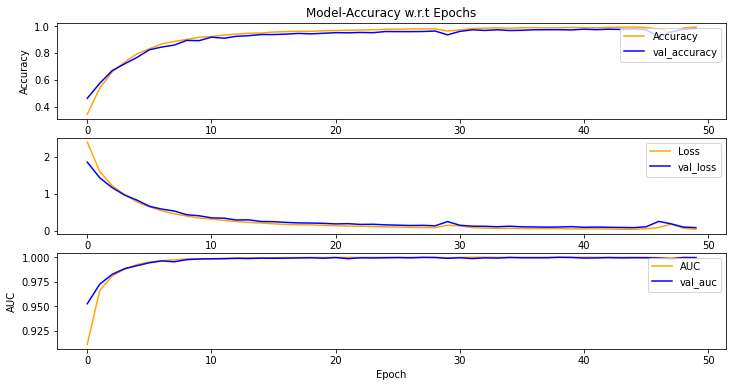

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax3.plot(history.history['auc'], color='orange', label='AUC')
ax3.plot(history.history['val_auc'], color='blue', label='val_auc')
ax3.set_xlabel("Epoch")
ax3.set_ylabel("AUC")
ax3.legend(loc='upper right')
plt.savefig('model_acc_LSTM_ESC50.png')

In [21]:
y_pred = model.predict(np.array(x).reshape(16000, 1,20))

In [23]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [24]:
y_pred_classes

array([18, 18, 18, ..., 18, 18, 18])

In [25]:
y_true = np.argmax(np.array(y_new), axis=1)

In [26]:
y_true

array([18, 18, 18, ..., 18, 18, 18])

In [27]:
print(np.mean(y_pred_classes == y_true))
m = AUC()
m.update_state(y_new, y_pred)
print(m.result())

0.9908125
tf.Tensor(0.99989295, shape=(), dtype=float32)


<Figure size 432x288 with 0 Axes>

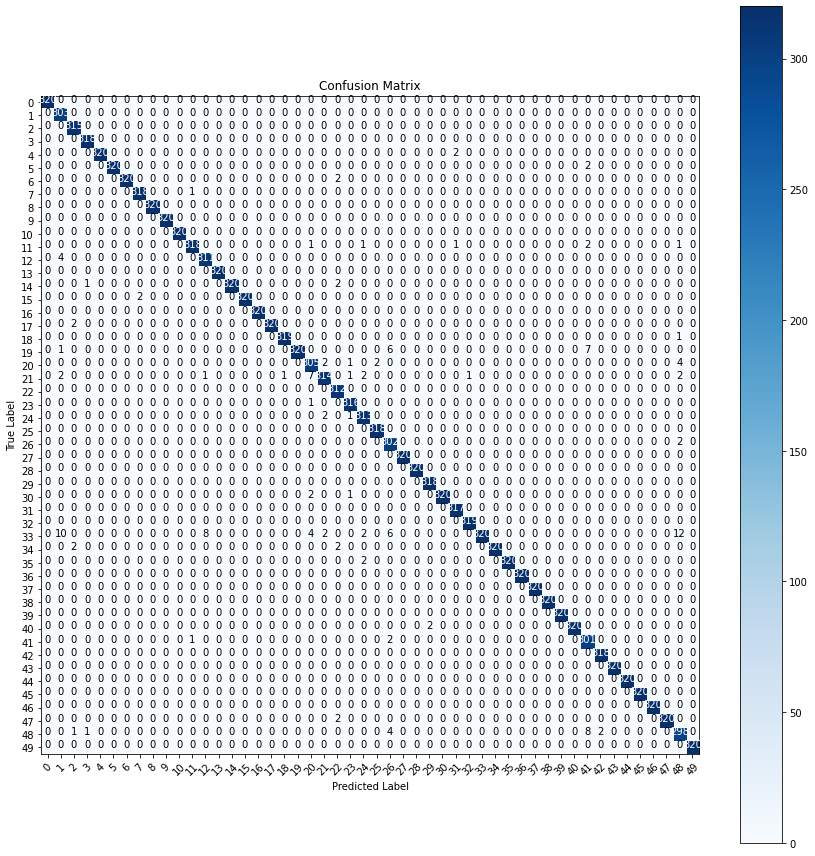

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_classes, y_true,)
import itertools
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(50)))
plt.xticks(tick_marks, range(50), rotation=45)
plt.yticks(tick_marks, range(50))
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('con_matrix_LSTM_ESC50.png')

In [29]:
test_results = []
answers = []
for index, row in tqdm(df.iterrows()):
    x,sr = librosa.load(audio_fpath+row['filename'], sr=44100)
    mfcc = librosa.feature.mfcc(y=x, sr=sr)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    sample = np.array(mfcc_mean).reshape(1, 1, 20)
    pred = model.predict(sample)
    pred_class = np.argmax(pred,axis=1 )
#     print(pred_class[0])
#     print(row['target'])
    test_results.append(pred_class[0])
    answers.append(row['category'])
print(np.mean(np.array(test_results) == np.array(answers)))

2000it [05:12,  6.39it/s]

0.0



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
